## Link Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#!ls "/content/gdrive/My Drive/Colab Notebooks/Capstone"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install xlrd

import tensorflow
tensorflow.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, CuDNNLSTM, GRU, CuDNNGRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

## Select Data

Don't run it again once we have the cleaned file.

In [0]:
def select_cols(cols=['Unnamed: 0','form','findexdate','only_eng_words','sec_full_path'],
                input_name = ['21centfoxinc','attinc','cbscorp','comcastcorp','verizoncom'],
                output_name = ['fox','att','cbs','comcast','verizon']):
  for i in range(len(input_name)):
    df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files/cleaned_data_updated_%s_sec_files.csv' % input_name[i],sep='|',
                     usecols=cols)
    if input_name[i]=='cbscorp':
      df = df[df['sec_full_path']!='https://www.sec.gov/Archives/edgar/data/813828/0000950136-06-004285.txt']
      df.reset_index(drop=True, inplace=True)
      df = df.drop(columns=['sec_full_path'])
    elif input_name[i]=='verizoncom':
      df = df[df['sec_full_path']!='https://www.sec.gov/Archives/edgar/data/732712/0000909518-11-000031.txt']
      df.reset_index(drop=True, inplace=True)
      df = df.drop(columns=['sec_full_path'])
    df.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/%s.csv' % output_name[i],index=False)
    
select_cols()

## Clean Dictionary

Don't run it again once we have the cleaned file.

In [0]:
lm_dic = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/LoughranMcDonald_MasterDictionary_2016.csv')
lm_words = lm_dic[['Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting','Modal']].astype(bool)
lm_dic_clean = lm_dic[lm_words.Negative | lm_words.Positive | lm_words.Uncertainty | lm_words.Litigious | lm_words.Constraining | lm_words.Superfluous | lm_words.Interesting | lm_words.Modal]
lm_dic_clean = lm_dic_clean[['Word','Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting','Modal']]
lm_dic_clean = lm_dic_clean.reset_index(drop=True)
lm_1 = lm_dic_clean[['Negative','Positive','Uncertainty','Litigious','Constraining','Superfluous','Interesting']]
lm_2 = lm_dic_clean[['Word','Modal']]
lm_1[lm_1>0]=1
lm_export = pd.merge(lm_2, lm_1, left_index=True, right_index=True)
lm_export.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/lm_dic_clean.csv',index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


## Load Dictionary

Don't run it again once we have the cleaned file.

In [0]:
lm = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/lm_dic_clean.csv')

## Load  SEC Filings and Map Sentiment

Don't run it again once we have the cleaned file.

In [0]:
# sentiment frequency

def map_sentiment(df):
  df_list = []
  result = []
  length = []
  for i in range(len(df)):
    print(i)
    cur_df = pd.DataFrame({'Word':df['only_eng_words'][i].split()})
    length.append(len(cur_df['Word']))
    # map each word with sentiment
    merged_df = pd.merge(cur_df,lm,how='inner')
    df_list.append(merged_df)
    result.append(list(merged_df.apply(np.sum,axis = 0))[1:])
  result = [*zip(*result)]   # take transpose
  result_df = pd.merge(df,pd.DataFrame({
                                        'Sentiment':df_list,
                                        'Modal':result[0],
                                        'Negative':result[1],
                                        'Positive':result[2],
                                        'Uncertainty':result[3],
                                        'Litigious':result[4],
                                        'Constraining':result[5],
                                        'Superfluous':result[6],
                                        'Interesting':result[7],
                                        'Doc_length':length
                                       }),left_index=True,right_index=True)
  result_df['Modal_freq'] = result_df['Modal']/result_df['Doc_length']
  result_df['Negative_freq'] = result_df['Negative']/result_df['Doc_length']
  result_df['Positive_freq'] = result_df['Positive']/result_df['Doc_length']
  result_df['Uncertainty_freq'] = result_df['Uncertainty']/result_df['Doc_length']
  result_df['Litigious_freq'] = result_df['Litigious']/result_df['Doc_length']
  result_df['Constraining_freq'] = result_df['Constraining']/result_df['Doc_length']
  result_df['Superfluous_freq'] = result_df['Superfluous']/result_df['Doc_length']
  result_df['Interesting_freq'] = result_df['Interesting']/result_df['Doc_length']
  result_df['Negative_score'] = (result_df['Negative']-result_df['Positive'])/result_df['Doc_length']
  return(result_df[['Unnamed: 0','form','findexdate','Sentiment','Modal_freq','Negative_freq','Positive_freq',
                   'Uncertainty_freq','Litigious_freq','Constraining_freq','Superfluous_freq','Interesting_freq',
                   'Negative_score']])

def map_sentiment_all(name = ['fox','att','cbs','comcast','verizon']):
  for company in name:
    sec = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sec_files_selected/%s.csv' % company)
    sec['only_eng_words'] = sec['only_eng_words'].str.upper()
    sec_sentiment = map_sentiment(sec)
    sec_sentiment.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/%s_sentiment.csv' % company,index=False)
    
map_sentiment_all()

## Stack Sentiment Features

Don't run it again once we have the cleaned file.

In [0]:
fox = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/fox_sentiment.csv')
comcast = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/comcast_sentiment.csv')
att = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/att_sentiment.csv')
verizon = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/verizon_sentiment.csv')
cbs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/cbs_sentiment.csv')
sentiment_features = pd.concat([fox,comcast,att,verizon,cbs],ignore_index=True)
sentiment_features = sentiment_features.sort_values('Unnamed: 0')
sentiment_features.to_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/sentiment_features_all.csv',index=False)

# Run Below

## Load Moody's Rating, Sentiment and Events

In [0]:
def load_data(company):
  '''
  The output of this function are used as inputs of interactive plots.
  '''
  moodys = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Capstone/Columbia DSIC 2018 - Moody\'s data.xlsx',sheet_name='Sheet1')
  if company == 'fox':
    mycompany = '21st Century Fox America'
    moodys = moodys.loc[moodys['Company']=='21st Century Fox America']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/fox_sentiment.csv')    
  elif company == 'verizon':
    mycompany = 'Verizon Communications Inc'
    moodys = moodys.loc[moodys['Company']=='Verizon Communications Inc']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/verizon_sentiment.csv')
  elif company == 'comcast':
    mycompany = 'Comcast Corp'
    moodys = moodys.loc[moodys['Company']=='Comcast Corp']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/comcast_sentiment.csv')
  elif company == 'att':
    mycompany = 'AT&T Corp'
    moodys = moodys.loc[moodys['Company']=='AT&T Corp']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/att_sentiment.csv')
  elif company == 'cbs':
    mycompany = 'CBS Corp'
    moodys = moodys.loc[moodys['Company']=='CBS Corp']
    moodys = moodys.sort_values("Effective Date")
    moodys = moodys.reset_index(drop=True)
    sentiment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/sentiment/cbs_sentiment.csv')  
  return((moodys,sentiment,mycompany))
# moodys, sentiment, company = load_data('verizon')

def remove_newlines(df):
  stripped = []
  for i in range(df.shape[0]):
    item = df['Item_text'][i][2:-2].replace('\\n','')
    stripped.append(item)
    #if item=='':
      #stripped.append('none')
    #else:
      #stripped.append(item)
  return stripped

def load_data_stacked(mycompany=['verizon','cbs','att','fox','comcast']):
  moodys,sentiment,company=load_data(mycompany[0])
  event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % mycompany[0],sep='|',usecols=['Item_text','Item_category'])
  for i in range(1,len(mycompany)):
    cur_moodys,cur_sentiment,cur_company=load_data(mycompany[i])
    if mycompany[i]=='fox':
      cur_event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % '21cent',sep='|',usecols=['Item_text','Item_category'])
    else:
      cur_event = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone/table_item/table_item_data_%s.csv' % mycompany[i],sep='|',usecols=['Item_text','Item_category'])
    sentiment = sentiment.append(cur_sentiment,ignore_index=True)
    event = event.append(cur_event,ignore_index=True)
    
    # remove new lines from event
    event['stripped_event'] = remove_newlines(event)
  
  sentiment['findexdate'] = pd.to_datetime(sentiment['findexdate'])
  return ((sentiment,event))


def data_merge(sentiment=load_data_stacked()[0],event=load_data_stacked()[1]):
  return pd.concat([sentiment, event], axis=1)

features = data_merge()

## Prepare Training Data

In [5]:
def prepare_train(num_words=1000,max_len=50,df = features):
  df_train = df[df['findexdate']<pd.to_datetime('2018-07-01')]
  df_test = df[df['findexdate']>=pd.to_datetime('2018-07-01')]
  
  t = Tokenizer(num_words=num_words)
  t.fit_on_texts(df_train['stripped_event'])
  x_train_text = t.texts_to_sequences(df_train['stripped_event'])
  x_train_text = pad_sequences(x_train_text, maxlen=max_len, padding='post')
  x_train_text = x_train_text.astype('float32')
  x_test_text = t.texts_to_sequences(df_test['stripped_event'])
  x_test_text = pad_sequences(x_test_text, maxlen=max_len, padding='post')
  x_test_text = x_test_text.astype('float32')
  
  
    
  x_train_tabular = df_train[['Modal_freq','Negative_freq','Positive_freq',
                              'Uncertainty_freq','Litigious_freq','Constraining_freq',
                              'Superfluous_freq','Interesting_freq','Negative_score']]
  x_test_tabular = df_test[['Modal_freq','Negative_freq','Positive_freq',
                            'Uncertainty_freq','Litigious_freq','Constraining_freq',
                            'Superfluous_freq','Interesting_freq','Negative_score']]
  
  
  
  y_train = ['A1']*78+['WR']*129+['A3']*183+['Baa1']*131+\
            ['Ba3']*16+['Ba2']*24+['Baa3']*11+['Baa1']*6+['A3']*79+['Baa3']*126+['Baa2']*115+\
            ['Aa3']*39+['A1']*25+['A2']*4+['A3']*4+['Baa2']*28+['Ba1']*41+['Baa2']*6+['A2']*196+['A3']*73+['Baa1']*124+['Baa2']*1+\
            ['Baa3']*74+['Baa2']*205+['Baa1']*758+\
            ['Ba1']*2+['Baa3']*32+['Baa2']*72+['Baa1']*59+['A3']*107 
  y_test = ['Baa1']*3+['Baa2']*7+['Baa2']*14+['Baa1']*11+['A3']*5
  
  # encode string labels into integer labels
  le = LabelEncoder()
  le.fit(y_train)
  print("Classes: ",le.classes_)
  
  y_train = le.transform(y_train)
  y_train = y_train.astype('int64')
  print("Train set distribution: \n",stats.itemfreq(y_train))
  y_train = np.reshape(y_train,(len(y_train),1))
  
  y_test = le.transform(y_test)
  y_test = y_test.astype('int64')
  print("Test set distribution: \n",stats.itemfreq(y_test))
  y_test = np.reshape(y_test,(len(y_test),1))
  
  return ((x_train_text,x_train_tabular,y_train,x_test_text,x_test_tabular,y_test))

x_train_text,x_train_tabular,y_train,x_test_text,x_test_tabular,y_test = prepare_train()

Classes:  ['A1' 'A2' 'A3' 'Aa3' 'Ba1' 'Ba2' 'Ba3' 'Baa1' 'Baa2' 'Baa3' 'WR']
Train set distribution: 
 [[   0  103]
 [   1  200]
 [   2  446]
 [   3   39]
 [   4   43]
 [   5   24]
 [   6   16]
 [   7 1078]
 [   8  427]
 [   9  243]
 [  10  129]]
Test set distribution: 
 [[ 2  5]
 [ 7 14]
 [ 8 21]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


## Prepare Plot Helper Functions

In [0]:
def get_distribution(myfreq):
  dist = [0]*11
  for i in range(len(myfreq)):
    dist[myfreq[i][0]]=myfreq[i][1]
  return dist

def autolabel(rects,ax):
  """
  Attach a text label above each bar displaying its height
  """
  for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '%d' % int(height),
            ha='center', va='bottom')

def plot_distribution(pred_label,actual_label):
  N = 11

  ind = np.arange(N)  # the x locations for the groups
  width = 0.36        # the width of the bars
  
  fig, ax = plt.subplots()
  fig.set_figheight(9)
  fig.set_figwidth(16)

  rects1 = ax.bar(ind, pred_label, width, color='#B284BE')

  rects2 = ax.bar(ind + width, actual_label, width, color='#547d8b')

  # add some text for labels, title and axes ticks
  ax.set_ylabel('Count')
  ax.set_title('Predict Label vs Actual Label')
  ax.set_xticks(ind + width / 2)
  ax.set_xticklabels(['A1', 'A2', 'A3', 'Aa3', 'Ba1', 'Ba2', 'Ba3', 'Baa1', 'Baa2', 'Baa3', 'WR'])

  ax.legend((rects1[0], rects2[0]), ('Predicted Label', 'Actual Label'))

  autolabel(rects1,ax)
  autolabel(rects2,ax)

  plt.show()


## Random Forest with Structured Data

{'randomforestclassifier__max_depth': array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
        4641.58883361, 10000.        ])}
Random Forest with Polynomial Features: {'randomforestclassifier__max_depth': 464.15888336127773} 0.5018195050946143


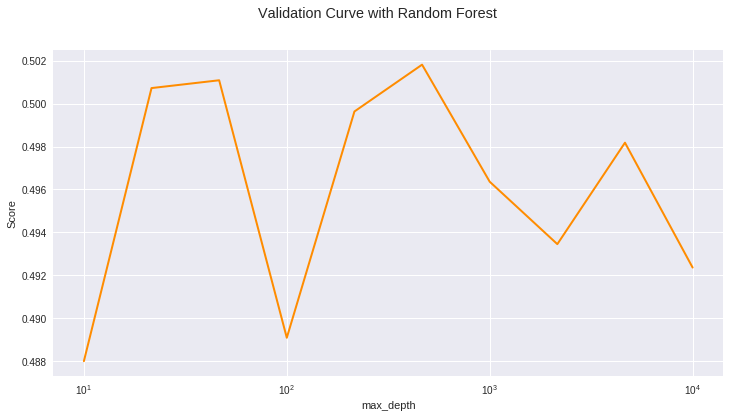

In [43]:
param_grid = {'randomforestclassifier__max_depth': np.logspace(1, 4, 10)}
print(param_grid)

rf_pipe = make_pipeline(RandomForestClassifier())
grid_rf = GridSearchCV(rf_pipe, param_grid, cv=10)
grid_rf.fit(x_train_tabular, np.reshape(y_train,(len(y_train),)))
print('Random Forest with Polynomial Features:', grid_rf.best_params_, grid_rf.best_score_ )

fig=plt.figure(figsize=(12, 6))
plt.suptitle("Validation Curve with Random Forest")
plt.xlabel("max_depth")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_grid['randomforestclassifier__max_depth'], grid_rf.cv_results_['mean_test_score'],
             label="Validation score",
             color="darkorange", lw=lw)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


Pred label on train set:
 [[   0  103]
 [   1  201]
 [   2  452]
 [   3   38]
 [   4   42]
 [   5   24]
 [   6   16]
 [   7 1077]
 [   8  433]
 [   9  234]
 [  10  128]]
Pred accuracy on train set:  0.9887190684133915
Pred label on test set:
 [[ 1  3]
 [ 2 10]
 [ 7 20]
 [ 8  5]
 [ 9  1]
 [10  1]]
Pred accuracy on test set:  0.275


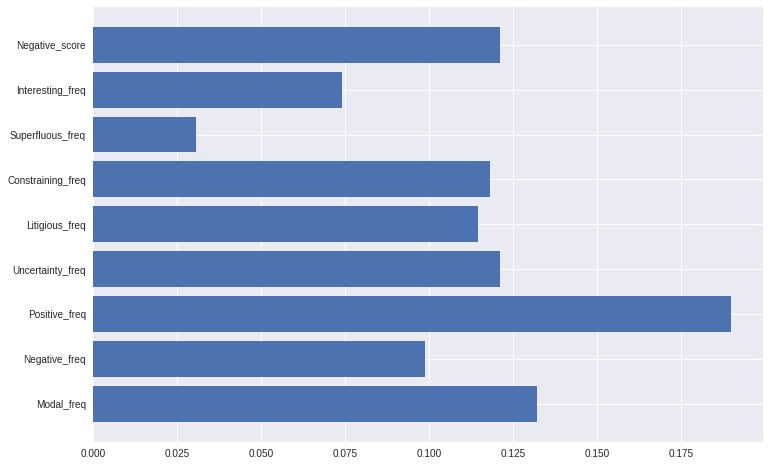

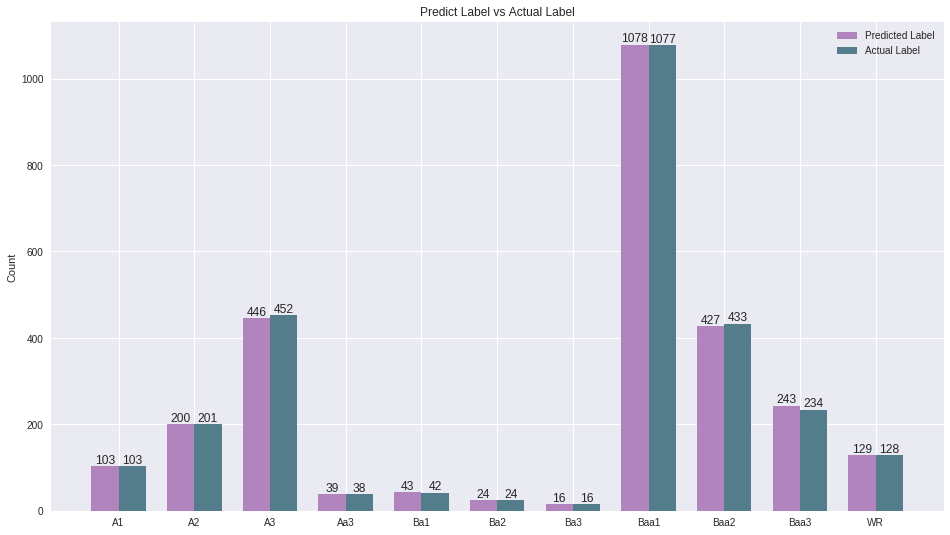

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  from ipykernel import kernelapp as app


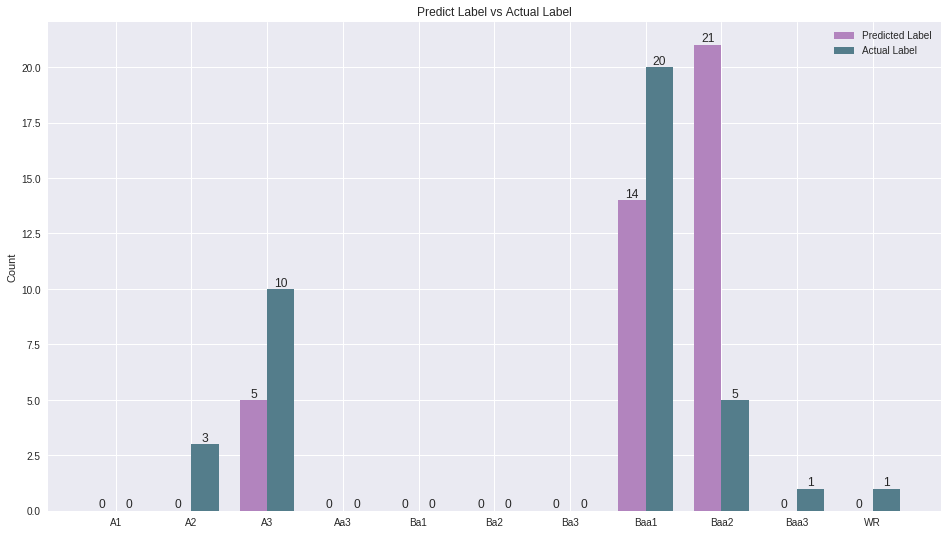

In [128]:
rf = RandomForestClassifier(max_depth=100).fit(x_train_tabular, np.reshape(y_train,(len(y_train),)))
rf.feature_importances_
print("Pred label on train set:\n", stats.itemfreq(rf.predict(x_train_tabular)))
print("Pred accuracy on train set: ", rf.score(x_train_tabular, y_train))
print("Pred label on test set:\n", stats.itemfreq(rf.predict(x_test_tabular)))
print("Pred accuracy on test set: ", rf.score(x_test_tabular, y_test))

fig=plt.figure(figsize=(12, 8))
plt.barh(range(9), rf.feature_importances_)
plt.yticks(range(9), ['Modal_freq','Negative_freq','Positive_freq',
                              'Uncertainty_freq','Litigious_freq','Constraining_freq',
                              'Superfluous_freq','Interesting_freq','Negative_score']);

plot_distribution(get_distribution(stats.itemfreq(y_train)), get_distribution(stats.itemfreq(rf.predict(x_train_tabular))))
plot_distribution(get_distribution(stats.itemfreq(y_test)), get_distribution(stats.itemfreq(rf.predict(x_test_tabular))))

## Neural Network with Unstrctured Data

In [129]:
# meta data
num_words = 1000
max_len = 50
embedding_size = 8
output_cat = 11

model = Sequential()
model.add(Embedding(num_words, embedding_size, input_shape=(max_len,)))
if tensorflow.test.is_gpu_available():
  model.add(CuDNNLSTM(64, return_sequences=True))
  model.add(CuDNNLSTM(64))
else:
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64))

model.add(Dense(64))
model.add(Dense(output_cat, activation='softmax'))
model.compile(tensorflow.train.AdamOptimizer(learning_rate=0.00001), 'sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=5,verbose=1)

history = model.fit(x_train_text, y_train, epochs=5, validation_split=0.1, verbose=1, callbacks=[early_stopping])

model.summary()

Epoch 1/5
78/78 [==============================] - 4s 52ms/step - loss: 2.3961 - acc: 0.1338 - val_loss: 2.3937 - val_acc: 0.2255
Epoch 2/5
78/78 [==============================] - 4s 51ms/step - loss: 2.3893 - acc: 0.4163 - val_loss: 2.3883 - val_acc: 0.2255
Epoch 3/5
78/78 [==============================] - 4s 51ms/step - loss: 2.3817 - acc: 0.4163 - val_loss: 2.3817 - val_acc: 0.2255
Epoch 4/5
78/78 [==============================] - 4s 51ms/step - loss: 2.3723 - acc: 0.4163 - val_loss: 2.3741 - val_acc: 0.2255
Epoch 5/5
78/78 [==============================] - 4s 52ms/step - loss: 2.3603 - acc: 0.4163 - val_loss: 2.3639 - val_acc: 0.2255
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 8)             8000      
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 50, 64)            18944     
____________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """


Pred label on train set:
 [[   7 2748]]
Pred accuracy on train set:  0.3922852983988355


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  from ipykernel import kernelapp as app


Pred label on test set:
 [[ 7 40]]
Pred accuracy on test set:  0.35


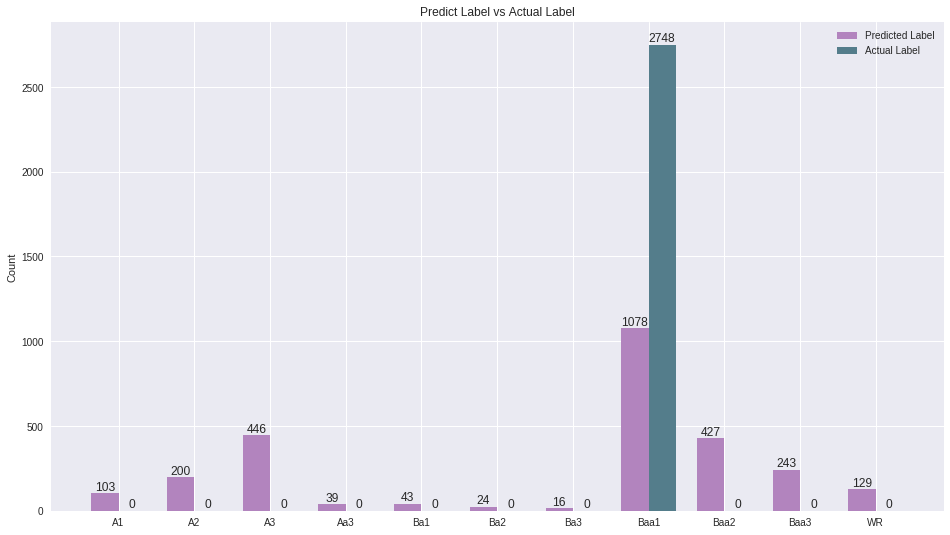

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


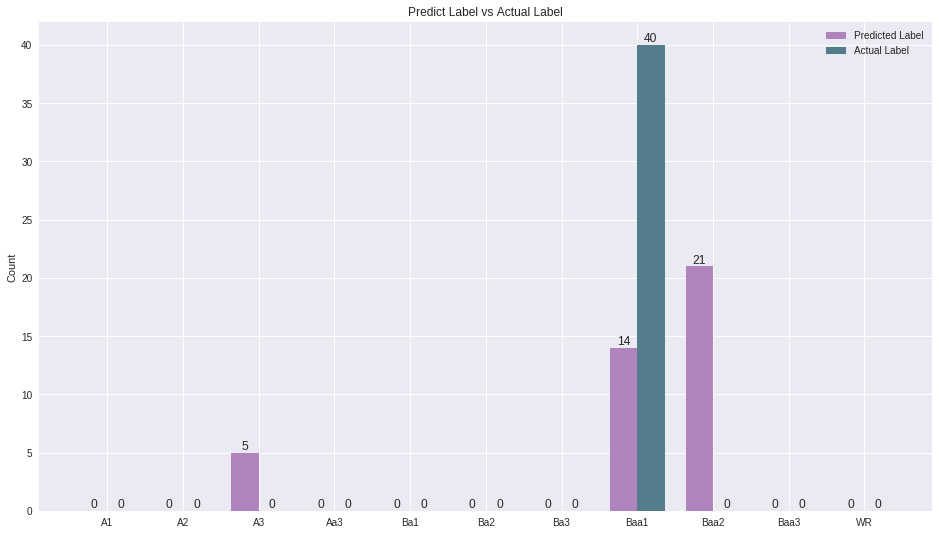

In [130]:
preds = model.predict(x_train_text)
pred_result_train = []
for i in range(len(x_train_text)):
  pred_result_train.append(np.argmax(preds[i]))
print("Pred label on train set:\n", stats.itemfreq(pred_result_train))
print("Pred accuracy on train set: ", sum(1 for x,y in zip(list(np.reshape(y_train,(len(y_train),))),pred_result_train) if x == y) / float(len(pred_result_train)))

preds = model.predict(x_train_text)
pred_result_test = []
for i in range(len(x_test_text)):
  pred_result_test.append(np.argmax(preds[i]))
print("Pred label on test set:\n", stats.itemfreq(pred_result_test))
print("Pred accuracy on test set: ", sum(1 for x,y in zip(list(np.reshape(y_test,(len(y_test),))),pred_result_test) if x == y) / float(len(pred_result_test)))

plot_distribution(get_distribution(stats.itemfreq(y_train)),get_distribution(stats.itemfreq(pred_result_train)))
plot_distribution(get_distribution(stats.itemfreq(y_test)),get_distribution(stats.itemfreq(pred_result_test)))

## Wide and Deep Model

In [131]:
# meta data
num_words = 1000
max_len = 50
embedding_size = 8
aux_input_cols = 9
output_cat = 11

# unstructured text
main_input = Input(shape=(max_len,), name='main_input')

x = Embedding(output_dim=embedding_size, input_dim=num_words, input_length=max_len)(main_input)

if tensorflow.test.is_gpu_available():
  rnnout = CuDNNGRU(32)(x)
else:
  rnnout = GRU(32, recurrent_activation='relu')(x)

auxiliary_output = Dense(output_cat, activation='softmax', name='aux_output')(rnnout)

# concat with structured tabular data frame
auxiliary_input = Input(shape=(aux_input_cols,), name='aux_input')
x = tensorflow.keras.layers.concatenate([rnnout, auxiliary_input])

#x = Conv1D(32, 7, activation='relu')(x)
#x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.2)(x)

# And finally add the main logistic regression layer
main_output = Dense(output_cat, activation='softmax', name='main_output')(x)



model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

model.compile(optimizer=tensorflow.train.AdamOptimizer(learning_rate=0.00001),
              loss={'main_output': 'sparse_categorical_crossentropy', 'aux_output': 'sparse_categorical_crossentropy'},
              loss_weights={'main_output': 0.5, 'aux_output': 1},
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_aux_output_acc',min_delta=0.001,patience=5,verbose=1)

history = model.fit({'main_input': x_train_text,
                     'aux_input': x_train_tabular},
                    {'main_output': y_train,
                     'aux_output': y_train},
                    validation_split=0.1, epochs=10, batch_size=128, verbose=1, callbacks=[early_stopping])

print(model.summary())

Epoch 1/10
20/20 [==============================] - 1s 56ms/step - loss: 3.6027 - main_output_loss: 2.3992 - aux_output_loss: 2.4031 - main_output_acc: 0.0675 - aux_output_acc: 0.0309 - val_loss: 3.5989 - val_main_output_loss: 2.4016 - val_aux_output_loss: 2.3981 - val_main_output_acc: 0.0218 - val_aux_output_acc: 0.0327
Epoch 2/10
20/20 [==============================] - 1s 52ms/step - loss: 3.6018 - main_output_loss: 2.3985 - aux_output_loss: 2.4026 - main_output_acc: 0.0819 - aux_output_acc: 0.0325 - val_loss: 3.5984 - val_main_output_loss: 2.4013 - val_aux_output_loss: 2.3977 - val_main_output_acc: 0.0255 - val_aux_output_acc: 0.0145
Epoch 3/10
20/20 [==============================] - 1s 51ms/step - loss: 3.6011 - main_output_loss: 2.3982 - aux_output_loss: 2.4020 - main_output_acc: 0.0879 - aux_output_acc: 0.0317 - val_loss: 3.5978 - val_main_output_loss: 2.4009 - val_aux_output_loss: 2.3973 - val_main_output_acc: 0.0291 - val_aux_output_acc: 0.0182
Epoch 4/10
20/20 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  from ipykernel import kernelapp as app


Pred label on train set:
 [[   0   65]
 [   1   16]
 [   2    1]
 [   3   16]
 [   4  165]
 [   5    2]
 [   7 1650]
 [  10  833]]
Pred accuracy on train set:  0.1957787481804949
Pred label on test set:
 [[ 4  8]
 [ 7 30]
 [10  2]]
Pred accuracy on test set:  0.3


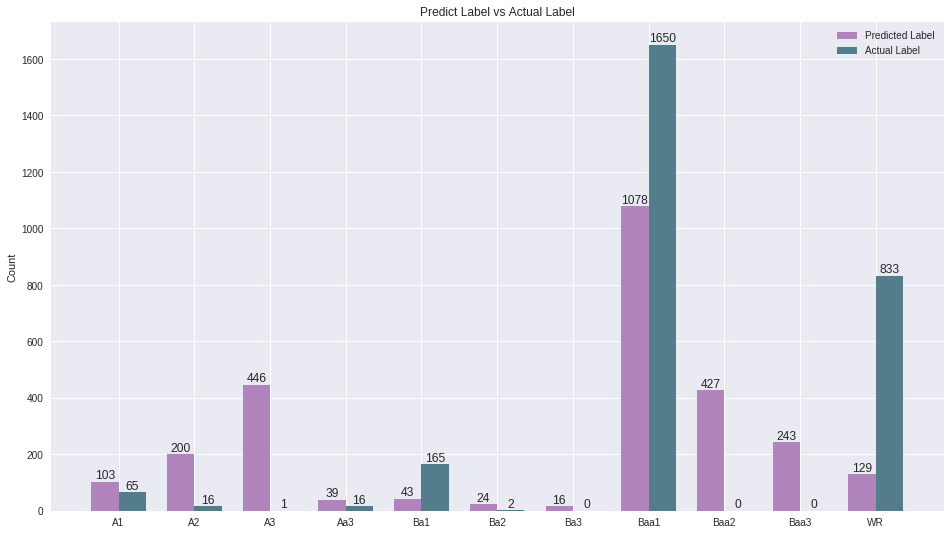

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


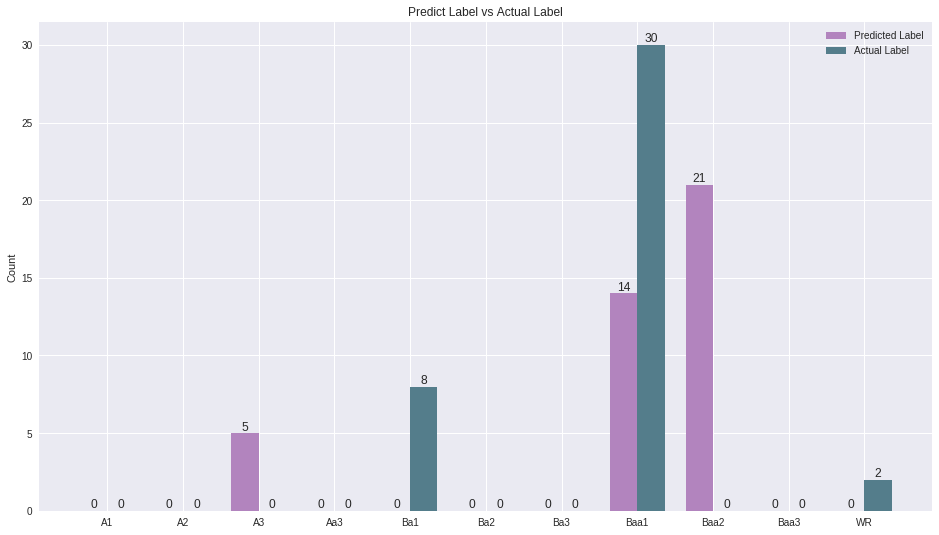

In [132]:
preds = model.predict({'main_input': x_train_text,'aux_input': x_train_tabular})
pred_result_train = []
for i in range(len(x_train_text)):
  pred_result_train.append(np.argmax(preds[0][i]))
print("Pred label on train set:\n", stats.itemfreq(pred_result_train))
print("Pred accuracy on train set: ", sum(1 for x,y in zip(list(np.reshape(y_train,(len(y_train),))),pred_result_train) if x == y) / float(len(pred_result_train)))

preds = model.predict({'main_input': x_test_text,'aux_input': x_test_tabular})
pred_result_test = []
for i in range(len(x_test_text)):
  pred_result_test.append(np.argmax(preds[0][i]))
print("Pred label on test set:\n", stats.itemfreq(pred_result_test))
print("Pred accuracy on test set: ", sum(1 for x,y in zip(list(np.reshape(y_test,(len(y_test),))),pred_result_test) if x == y) / float(len(pred_result_test)))

plot_distribution(get_distribution(stats.itemfreq(y_train)),get_distribution(stats.itemfreq(pred_result_train)))
plot_distribution(get_distribution(stats.itemfreq(y_test)),get_distribution(stats.itemfreq(pred_result_test)))

## EDA

In [0]:
def plot(df):
  
  date = df['findexdate']

  plt.figure(figsize=(20,8))
  plt.plot(date, df['Negative_freq'], 'b-', label='Negative Freq')
  plt.plot(date, df['Positive_freq'], 'r-', label='Positive Freq')
  plt.plot(date, df['Modal_freq'], 'y-', label='Modal Freq')
  plt.plot(date, df['Uncertainty_freq'], 'g-', label='Uncertainty Freq')
  plt.plot(date, df['Litigious_freq'], label='Litigious Freq')
  plt.plot(date, df['Constraining_freq'], label='Constraining Freq')
  plt.plot(date, df['Superfluous_freq'], label='Superfluous Freq')
  plt.plot(date, df['Interesting_freq'], label='Interesting Freq')
  plt.xticks(rotation=90)
  plt.title('Sentiment Frequency')
  plt.legend()

  plt.figure()

  plt.show()

## Plotly Frequency

In [0]:
# sentiment frequency
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

#import scipy
#from scipy import signal
#signal.savgol_filter

plotly.tools.set_credentials_file(username='yunwencai', api_key='9R0DAo2gnrurCju4VJQM')

def interactive_plot(moodys,df,company):

  # All
  negative_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq = go.Scatter(
      x = df['findexdate'],
      y = df['Interesting_freq'],
      name = "Interesting Frequency"
  ) 
  negative_score = go.Scatter(
      x = df['findexdate'],
      y = df['Negative_score'],
      name = "Negative Score"
  ) 
  
  # 10-K
  negative_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_score'],
      name = "Negative Score"
  )
  
  # 8-K
  negative_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = df[df['form']=='8-K']['Negative_score'],
      name = "Negative Score"
  )
  
  # 10-Q
  negative_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = df[df['form']=='10-Q']['Negative_score'],
      name = "Negative Score"
  )
  
  moodys_text = go.Scatter(
    x=moodys['Effective Date'],
    #y=[df.drop(['Unnamed: 0'],axis=1)._get_numeric_data().max(axis=0).max()]*moodys.shape[0],
    y=[0]*moodys.shape[0],
    mode='markers+text',
    name='Moody\'s Rating',
    text=moodys['Moody\'s Rating'],
    textposition='bottom center',
    textfont=dict(
        family='sans serif',
        size=12,
        color='#ff7f0e'
    )
  )
  
  layout = dict(
    title=company+' Sentiment Frequency',
    xaxis=dict(
        title='Date',
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='YTD',
                     step='year',
                     stepmode='backward'),
                dict(count=5,
                     label='5y',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10y',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis=dict(title='Frequency')
  )
  
  updatemenus = list([
    dict(active=-1,
         buttons=list([   
            dict(label = 'All Filings',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' All Filings'}]),
            dict(label = '10-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 10-Ks'}]),
            dict(label = '8-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 8-Ks'}]),
            dict(label = '10-Qs',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      True]},
                         {'title': company+' 10-Qs'}])
        ]),
      )
  ])
  
  layout['updatemenus'] = updatemenus

  data = [negative_freq, positive_freq, modal_freq, uncertainty_freq,
         litigious_freq, constraining_freq, superfluous_freq, interesting_freq,negative_score,
         negative_freq_10k, positive_freq_10k, modal_freq_10k, uncertainty_freq_10k,
         litigious_freq_10k, constraining_freq_10k, superfluous_freq_10k, interesting_freq_10k,negative_score_10k,
         negative_freq_8k, positive_freq_8k, modal_freq_8k, uncertainty_freq_8k,
         litigious_freq_8k, constraining_freq_8k, superfluous_freq_8k, interesting_freq_8k,negative_score_8k,
         negative_freq_10q, positive_freq_10q, modal_freq_10q, uncertainty_freq_10q,
         litigious_freq_10q, constraining_freq_10q, superfluous_freq_10q, interesting_freq_10q,negative_score_10q,
         moodys_text]  
  fig = dict(data=data, layout=layout)

  #plotly.offline.plot(fig, filename='fox_sentiment_analysis.html', auto_open=False)
  return py.iplot(fig, filename=company+' Sentiment Frequency')

interactive_plot(moodys,sentiment,company)

##Plotly Frequency with Smoothing

In [0]:
# sentiment frequency
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import scipy
from scipy import signal
#signal.savgol_filter

plotly.tools.set_credentials_file(username='yunwencai', api_key='9R0DAo2gnrurCju4VJQM')

def interactive_plot(moodys,df,company):

  # All
  negative_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Negative_freq'],19,3),
      name = "Negative Frequency"
  )
  positive_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Positive_freq'],19,3),
      name = "Positive Frequency"
  )
  modal_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Modal_freq'],19,3),
      name = "Modal Frequency"
  )
  uncertainty_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Uncertainty_freq'],19,3),
      name = "Uncertainty Frequency"
  )
  litigious_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Litigious_freq'],19,3),
      name = "Litigious Frequency"
  )
  constraining_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Constraining_freq'],19,3),
      name = "Constraining Frequency"
  )
  superfluous_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Superfluous_freq'],19,3),
      name = "Superfluous Frequency"
  )
  interesting_freq = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Interesting_freq'],19,3),
      name = "Interesting Frequency"
  ) 
  negative_score = go.Scatter(
      x = df['findexdate'],
      y = signal.savgol_filter(df['Negative_score'],19,3),
      name = "Negative Score"
  ) 
  
  # 10-K
  negative_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_freq'],
      name = "Negative Frequency"
  )
  positive_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Positive_freq'],
      name = "Positive Frequency"
  )
  modal_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Modal_freq'],
      name = "Modal Frequency"
  )
  uncertainty_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Uncertainty_freq'],
      name = "Uncertainty Frequency"
  )
  litigious_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Litigious_freq'],
      name = "Litigious Frequency"
  )
  constraining_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Constraining_freq'],
      name = "Constraining Frequency"
  )
  superfluous_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Superfluous_freq'],
      name = "Superfluous Frequency"
  )
  interesting_freq_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Interesting_freq'],
      name = "Interesting Frequency"
  )
  negative_score_10k = go.Scatter(
      x = df[df['form']=='10-K']['findexdate'],
      y = df[df['form']=='10-K']['Negative_score'],
      name = "Negative Score"
  )
  
  # 8-K
  negative_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Negative_freq'],19,3),
      name = "Negative Frequency"
  )
  positive_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Positive_freq'],19,3),
      name = "Positive Frequency"
  )
  modal_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Modal_freq'],19,3),
      name = "Modal Frequency"
  )
  uncertainty_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Uncertainty_freq'],19,3),
      name = "Uncertainty Frequency"
  )
  litigious_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Litigious_freq'],19,3),
      name = "Litigious Frequency"
  )
  constraining_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Constraining_freq'],19,3),
      name = "Constraining Frequency"
  )
  superfluous_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Superfluous_freq'],19,3),
      name = "Superfluous Frequency"
  )
  interesting_freq_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Interesting_freq'],19,3),
      name = "Interesting Frequency"
  )
  negative_score_8k = go.Scatter(
      x = df[df['form']=='8-K']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='8-K']['Negative_score'],19,3),
      name = "Negative Score"
  )
  
  # 10-Q
  negative_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Negative_freq'],19,3),
      name = "Negative Frequency"
  )
  positive_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Positive_freq'],19,3),
      name = "Positive Frequency"
  )
  modal_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Modal_freq'],19,3),
      name = "Modal Frequency"
  )
  uncertainty_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Uncertainty_freq'],19,3),
      name = "Uncertainty Frequency"
  )
  litigious_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Litigious_freq'],19,3),
      name = "Litigious Frequency"
  )
  constraining_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Constraining_freq'],19,3),
      name = "Constraining Frequency"
  )
  superfluous_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Superfluous_freq'],19,3),
      name = "Superfluous Frequency"
  )
  interesting_freq_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Interesting_freq'],19,3),
      name = "Interesting Frequency"
  )
  negative_score_10q = go.Scatter(
      x = df[df['form']=='10-Q']['findexdate'],
      y = signal.savgol_filter(df[df['form']=='10-Q']['Negative_score'],19,3),
      name = "Negative Score"
  )
  
  moodys_text = go.Scatter(
    x=moodys['Effective Date'],
    #y=[df.drop(['Unnamed: 0'],axis=1)._get_numeric_data().max(axis=0).max()]*moodys.shape[0],
    y=[0]*moodys.shape[0],
    mode='markers+text',
    name='Moody\'s Rating',
    text=moodys['Moody\'s Rating'],
    textposition='bottom center',
    textfont=dict(
        family='sans serif',
        size=12,
        color='#ff7f0e'
    )
  )
  
  layout = dict(
    title=company+' Sentiment Frequency',
    xaxis=dict(
        title='Date',
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='YTD',
                     step='year',
                     stepmode='backward'),
                dict(count=5,
                     label='5y',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10y',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis=dict(title='Frequency')
  )
  
  updatemenus = list([
    dict(active=-1,
         buttons=list([   
            dict(label = 'All Filings',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' All Filings'}]),
            dict(label = '10-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 10-Ks'}]),
            dict(label = '8-Ks',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      False, False, False, False, False, False, False, False, False,
                                      True]},
                         {'title': company+' 8-Ks'}]),
            dict(label = '10-Qs',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      False, False, False, False, False, False, False, False, False,
                                      True, True, True, True, True, True, True, True, True,
                                      True]},
                         {'title': company+' 10-Qs'}])
        ]),
      )
  ])
  
  layout['updatemenus'] = updatemenus

  data = [negative_freq, positive_freq, modal_freq, uncertainty_freq,
         litigious_freq, constraining_freq, superfluous_freq, interesting_freq,negative_score,
         negative_freq_10k, positive_freq_10k, modal_freq_10k, uncertainty_freq_10k,
         litigious_freq_10k, constraining_freq_10k, superfluous_freq_10k, interesting_freq_10k,negative_score_10k,
         negative_freq_8k, positive_freq_8k, modal_freq_8k, uncertainty_freq_8k,
         litigious_freq_8k, constraining_freq_8k, superfluous_freq_8k, interesting_freq_8k,negative_score_8k,
         negative_freq_10q, positive_freq_10q, modal_freq_10q, uncertainty_freq_10q,
         litigious_freq_10q, constraining_freq_10q, superfluous_freq_10q, interesting_freq_10q,negative_score_10q,
         moodys_text]  
  fig = dict(data=data, layout=layout)

  #plotly.offline.plot(fig, filename='cbs_sentiment_analysis.html', auto_open=False)
  return py.iplot(fig, filename=company+' Sentiment Frequency')

interactive_plot(moodys,sentiment,company)

In [0]:
#!ls
#!mv /content/cbs_sentiment_analysis.html /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone/sentiment_frequency_plot_w_smoothing

cbs_sentiment_analysis.html  gdrive  sample_data
